In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

key_day = "LS"
data_dir = f'../data/data{key_day}'
dataset_dir = f'../data/dataset{key_day}'

##ESCOGER MENOR TAMAÑO DE CARPETA

folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
tamanos =[]
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    file_count = len(os.listdir(folder_path))
    tamanos.append(file_count)

menor = min(tamanos)
print(menor)

##LIMITAR A MENOR TAMAÑO DE CARPETA
carpeta_fuente = data_dir
carpeta_destino = dataset_dir

carpetas = os.listdir(carpeta_fuente)

for carpeta in carpetas:
    if not carpeta.startswith("."):
        imagenes = os.listdir(carpeta_fuente + '/' + carpeta)

        for i, nombreimg in enumerate(imagenes):
            if i < 42:
                if not nombreimg.startswith("."):
                    shutil.copy(carpeta_fuente + '/' + carpeta + '/' + nombreimg, carpeta_destino + '/' + carpeta + '/' + nombreimg)

##CREAR GENERADORES DE IMAGENES CON DATA AUGMENTATION
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

##GENERADORES PARA ENTRENAMIENTO Y PRUEBAS
data_gen_entrenamiento = datagen.flow_from_directory(dataset_dir, target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory(dataset_dir, target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

43
Found 203 images belonging to 6 classes.
Found 48 images belonging to 6 classes.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

#Congelar el modelo descargado
mobilenetv2.trainable = False

In [6]:
from tensorflow.keras.models import load_model

modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(6, activation='softmax')
])
 
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [8]:
import spicy

#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50
7/7 [==============================] - 15s 2s/step - loss: 2.1376 - accuracy: 0.1823 - val_loss: 1.9053 - val_accuracy: 0.2917
Epoch 2/50
7/7 [==============================] - 8s 1s/step - loss: 1.6947 - accuracy: 0.3448 - val_loss: 1.6830 - val_accuracy: 0.3125
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 1.4641 - accuracy: 0.4187 - val_loss: 1.5918 - val_accuracy: 0.2708
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 1.3249 - accuracy: 0.5172 - val_loss: 1.4196 - val_accuracy: 0.4167
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 1.1880 - accuracy: 0.5468 - val_loss: 1.4416 - val_accuracy: 0.3958
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 1.0566 - accuracy: 0.6059 - val_loss: 1.2938 - val_accuracy: 0.4375
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 1.0074 - accuracy: 0.6404 - val_loss: 1.3839 - val_accuracy: 0.3958
Epoch 8/50
7/7 [========================

In [9]:
from tensorflow.keras.models import save_model

save_model(modelo, f'../models/{key_day}.h5')


C:\Users\super\AppData\Local\Temp\ipykernel_18436\3256685166.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(modelo, './models/modeloLS.h5')


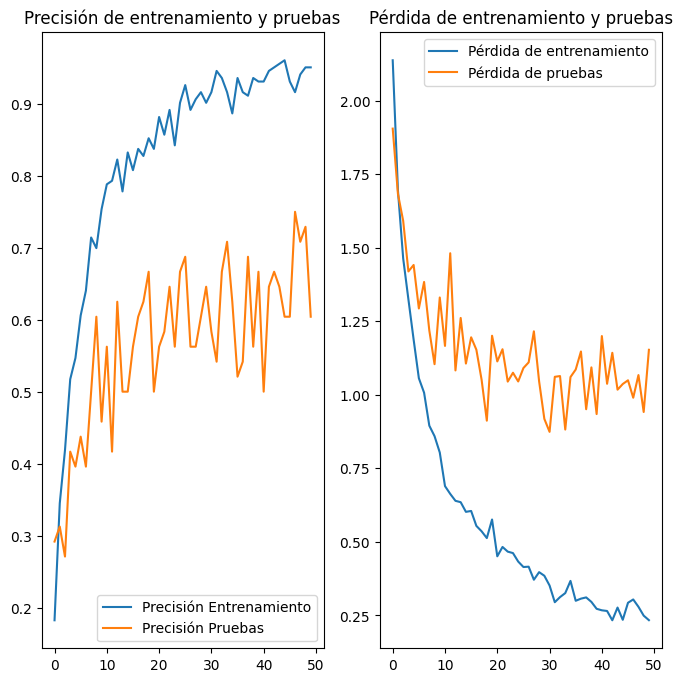

In [10]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'KerasLayer': hub.KerasLayer}
modelo = load_model('modelo.h5', custom_objects=custom_objects)